# Reionised bubbles around primordial galaxies

## Introduction

This is the third ipython notebook to be followed alongside the exercise sheet. Again, the following code only serves as a starting point, feel free to adjust it as you see fit. Software requirements are discussed in the first notebook.

In [1]:
# Load necessary packages
import warnings

import numpy as np

import matplotlib
%matplotlib inline
print("Matplotlib", matplotlib.__version__, "(backend: " + matplotlib.get_backend() + ')')
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("ticks")

# Load matplotlib style file
plt.style.use("../auxiliary/bubble.mplstyle")
def_linewidth = plt.rcParams["lines.linewidth"]
def_markersize = plt.rcParams["lines.markersize"]

pformat = ".png"
dpi = 300

# Import astropy cosmology, given H0 and Omega_matter (Planck Collaboration 2020)
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315, Ob0=0.02237/0.674**2, Tcmb0=2.726)

from astropy import table, units
from astropy.coordinates import SkyCoord

Matplotlib 3.10.0 (backend: inline)


## Using custom code modelling the IGM absorption of Lyα

In the following, we will use pre-written code from a module called [`lymana_absorption`](https://github.com/joriswitstok/lymana_absorption). First, you can obtain the source code with:
```
$ git clone https://github.com/joriswitstok/lymana_absorption.git
```
Then, you can follow the repository's instructions to install the code into your anaconda environment (double checking if it is still activated):
```
$ cd lymana_absorption
$ which pip3
pip3 install .
```

In [2]:
try:
    from lymana_absorption.lymana_optical_depth import *
    from lymana_absorption.fund_constants import wl_Lya
except:
    warnings.warn("lymana_absorption installation not found. Modules not available", UserWarning)

## Test code installation

The following block illustrates the usage of the `tau_IGM` function, providing the Lyα optical depth due to IGM absorption, by reproducing Figure 1 from Mason & Gronke (2020).

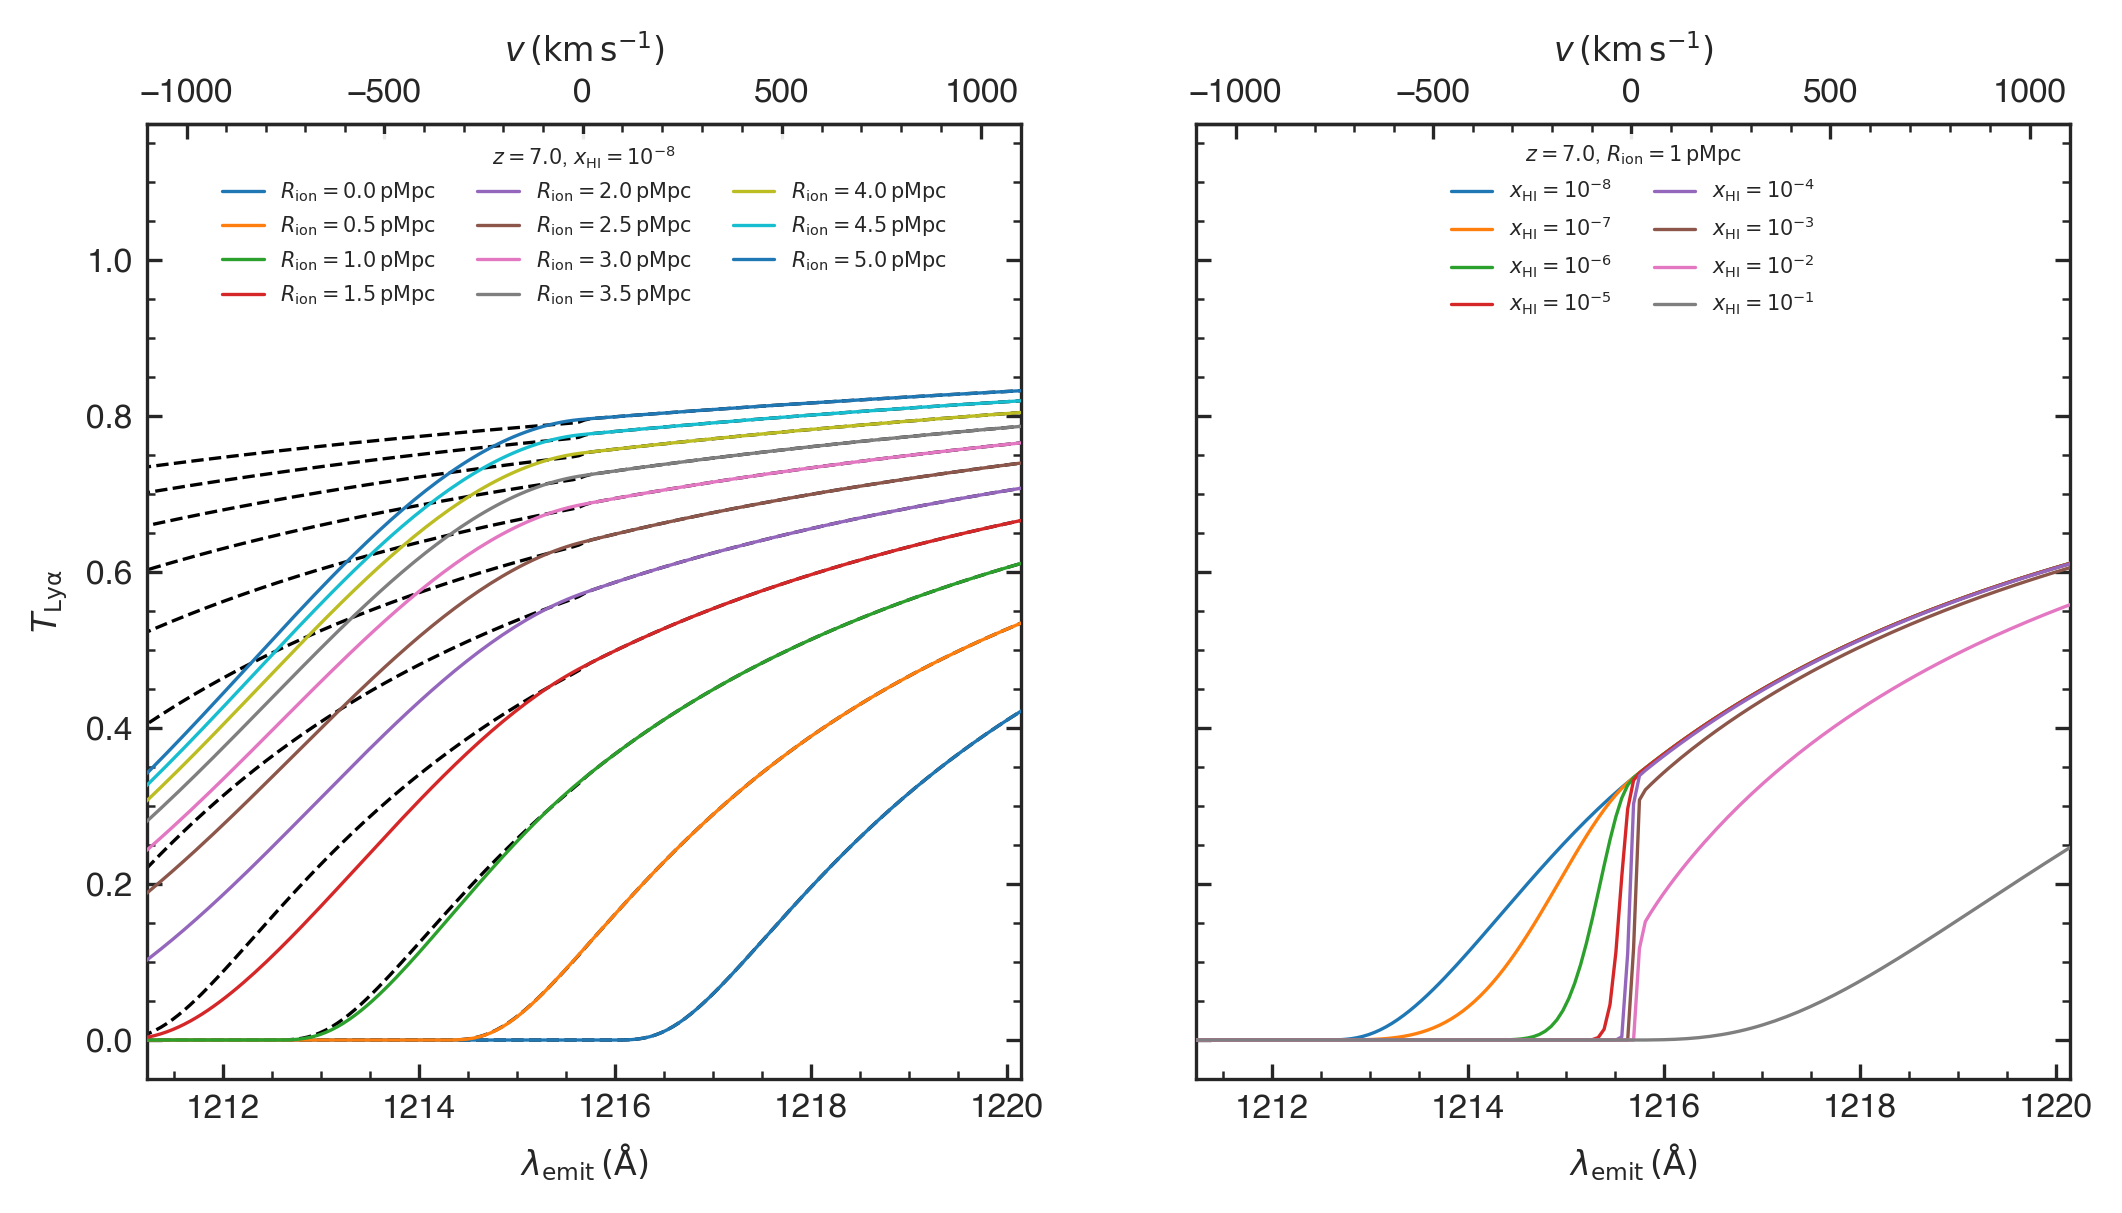

In [3]:
# Example calculation for IGM transmission curves, inspired by Mason & Gronke (2020)
z_source = 7.0
wl_emit_array = np.linspace(1200, 1230, 500)
wl_obs_array = wl_emit_array * (1.0 + z_source)

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8.27, 8.27/2))

ax = axes[0]
ax_v = ax.secondary_xaxis("top", functions=(lambda wl: (1.0 - wl_Lya/wl)*299792.458, lambda v: wl_Lya / (1.0 - v/299792.458)))
ax.tick_params(axis="both", which="both", top=False)

x_HI = 1e-8
for R_ion in np.arange(0.0, 5.25, 0.5):
    ax.plot(wl_emit_array, np.exp(-tau_IGM(wl_obs_array, z_source, R_ion=R_ion, x_HI=x_HI, cosmo=cosmo)), linestyle='--', color='k')
    ax.plot(wl_emit_array, np.exp(-tau_IGM(wl_obs_array, z_source, R_ion=R_ion, x_HI=x_HI, x_HI_profile="quadratic", cosmo=cosmo)),
            label=r"$R_\mathrm{{ion}} = {:.1f} \, \mathrm{{pMpc}}$".format(R_ion), zorder=5)

ax.set_xlim(wl_Lya / (1.0 + 1100/299792.458), wl_Lya / (1.0 - 1100/299792.458))
ax.set_ylim(-0.05, 1.175)

ax.set_xlabel(r"$\lambda_\mathrm{emit} \, (\mathrm{\AA})$")
ax_v.set_xlabel(r"$v \, (\mathrm{km \, s^{{-1}}})$")
ax.set_ylabel(r"$T_\mathrm{Ly\alpha}$")

leg = ax.legend(ncol=3, loc="upper center", fontsize="small")
leg.set_title(r"$z = {:.1f}$, $x_\mathrm{{HI}} = 10^{{-8}}$".format(z_source), prop={"size": "small"})

ax = axes[1]
ax_v = ax.secondary_xaxis("top", functions=(lambda wl: (1.0 - wl_Lya/wl)*299792.458, lambda v: wl_Lya / (1.0 - v/299792.458)))
ax.tick_params(axis="both", which="both", top=False)

R_ion = 1.0 # Mpc
for x_HI in 10**np.arange(-8.0, 0.0):
    ax.plot(wl_emit_array, np.exp(-tau_IGM(wl_obs_array, z_source, R_ion=R_ion, x_HI=x_HI, x_HI_profile="quadratic", cosmo=cosmo)),
            label=r"$x_\mathrm{{HI}} = 10^{{{:.0f}}}$".format(np.log10(x_HI)), zorder=5)

ax.set_xlabel(r"$\lambda_\mathrm{emit} \, (\mathrm{\AA})$")
ax_v.set_xlabel(r"$v \, (\mathrm{km \, s^{{-1}}})$")

leg = ax.legend(ncol=2, loc="upper center", fontsize="small")
leg.set_title(r"$z = {:.1f}$, $R_\mathrm{{ion}} = 1 \, \mathrm{{pMpc}}$".format(z_source), prop={"size": "small"})

fig.savefig("../plots/Lya_bubble_transmission" + pformat, dpi=dpi, bbox_inches="tight")

plt.show()
plt.close(fig)

## Infer ionised bubble size of ID 10013682 in GOODS-S

The inferred ionised bubble radius is R_ion = 2.635 -1.272 +4.322 pMpc.

Given the ionising photon efficiency measured to be log ξ_ion = 25.66 Hz/erg by Saxena et al. (2024),
which at M_UV = -17.0 mag translates to an ionising photon production rate dN_ion/dt = 0.13 x 10^54 Hz.
At this rate, it would take a time period of 60.7 Gyr to create this ionised region itself,
compared to the age of the Universe at z = 7.28 of 0.7 Gyr


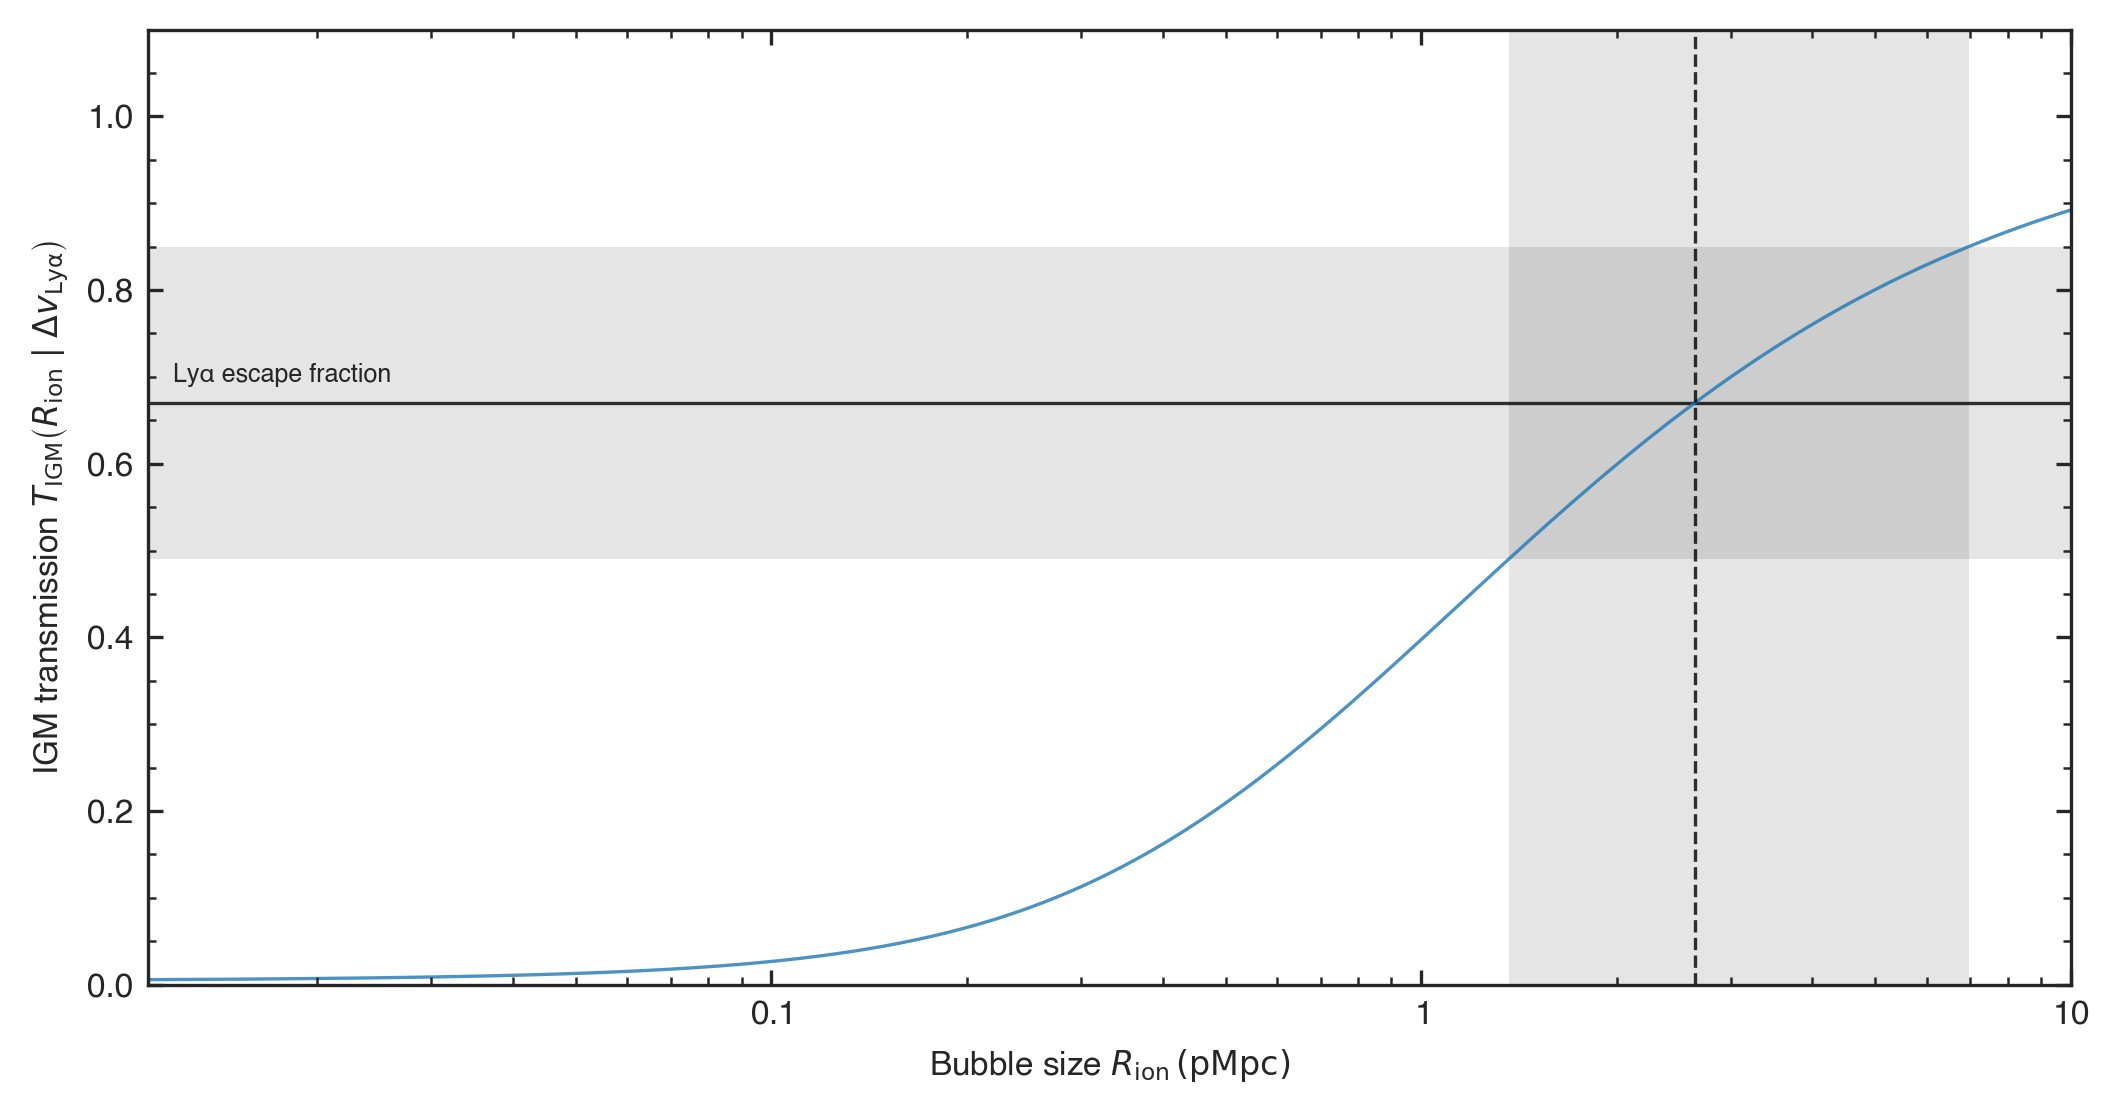

In [4]:
# Values from Witstok et al. (2024)
z_sys = 7.276 # systemic redshift
deltav_Lya = 178.4 # km/s
f_esc_Lya = 0.67
f_esc_Lya_err = 0.18
wl_obs_Lya = wl_Lya / (1.0 - deltav_Lya/299792.458) * (1.0 + z_sys)

x_HI = 1e-8
x_HI_global = 1.0
R_ions = np.geomspace(0.001, 10, 500)

fig, ax = plt.subplots(figsize=(8.27, 8.27/2))

ax.axhline(y=f_esc_Lya, color='k', alpha=0.8)
ax.fill_between([0, 1], y1=f_esc_Lya-f_esc_Lya_err, y2=f_esc_Lya+f_esc_Lya_err, transform=ax.get_yaxis_transform(), edgecolor="None", facecolor='k', alpha=0.1)
ax.annotate(text="Lyα escape fraction", xy=(0, f_esc_Lya), xytext=(6, 4),
            xycoords=ax.get_yaxis_transform(), textcoords="offset points", va="bottom", ha="left")

transmissions = np.array([np.exp(-tau_IGM(wl_obs_Lya, z_sys, R_ion=R_ion, x_HI=x_HI,
                                                x_HI_profile="quadratic", x_HI_global=x_HI_global, cosmo=cosmo)) for R_ion in R_ions])

R_ion_esc = np.interp(f_esc_Lya, transmissions, R_ions)
R_ion_esc_lowerr = R_ion_esc - np.interp(f_esc_Lya-f_esc_Lya_err, transmissions, R_ions)
R_ion_esc_uperr = np.interp(f_esc_Lya+f_esc_Lya_err, transmissions, R_ions) - R_ion_esc
print("The inferred ionised bubble radius is R_ion = {:.3f} -{:.3f} +{:.3f} pMpc.".format(R_ion_esc, R_ion_esc_lowerr, R_ion_esc_uperr))

# Values from Saxena et al. (2024)
M_UV_LAE = -17.0 # AB mag
F_nu_UV = 10**((M_UV_LAE+48.60)/-2.5) # erg/s/cm^2/Hz
L_nu_UV = F_nu_UV * 4.0 * np.pi * (10.0*3.0857e18)**2 # erg/s/Hz
logxi_ion = 25.66 # Hz/erg
dN_ion_dt = 10**logxi_ion * L_nu_UV # Hz

# Mean hydrogen number density at redshift z (converted to Mpc^-3)
n_H_0 = 1.88e-7 # hydrogen number density at z = 0 in cm^-3
n_H = (n_H_0 * (1.0 + z_sys)**3 * units.cm**-3).to("Mpc^-3").value
t_req = (4.0 * np.pi * R_ion_esc**3 * n_H / (3.0 * dN_ion_dt) * units.s).to("Gyr")
print("\nGiven the ionising photon efficiency measured to be log ξ_ion = {:.2f} Hz/erg by Saxena et al. (2024),".format(logxi_ion))
print("which at M_UV = {:.1f} mag translates to an ionising photon production rate dN_ion/dt = {:.2f} x 10^54 Hz.".format(M_UV_LAE, dN_ion_dt/1e54))
print("At this rate, it would take a time period of {:.1f} to create this ionised region itself,".format(t_req))
print("compared to the age of the Universe at z = {:.2f} of {:.1f}".format(z_sys, cosmo.age(z_sys).to("Gyr")))

ax.plot(R_ions, transmissions, alpha=0.8)
ax.axvline(x=R_ion_esc, linestyle='--', color='k', alpha=0.8)
ax.fill_between([R_ion_esc-R_ion_esc_lowerr, R_ion_esc+R_ion_esc_uperr], y1=0, y2=1,
                transform=ax.get_xaxis_transform(), edgecolor="None", facecolor='k', alpha=0.1)

ax.set_xscale("log")

ax.set_xlim(np.min(R_ions)+0.01, np.max(R_ions))
ax.set_ylim(0.0, 1.1)

ax.set_xlabel(r"Bubble size $R_\mathrm{ion} \, (\mathrm{pMpc})$")
ax.set_ylabel(r"IGM transmission $T_\mathrm{IGM} \left( R_\mathrm{ion} \mid \Delta v_\mathrm{Ly\alpha} \right)$")

fig.savefig("../plots/Transmission_LAE_bubble_sizes" + pformat, dpi=dpi, bbox_inches="tight")

plt.show()
plt.close(fig)

## Visualise the environment of ID 10013682 in GOODS-S

To do this, we will load the catalogue from Helton et al. (2024), selecting all galaxies spectroscopically confirmed in the FRESCO wide-field slitless survey.

In [5]:
# Read in FRESCO catalogue
FRESCO_cat = table.Table.read("../data/Helton_2024_Catalog.csv")

select = FRESCO_cat["Field"] == "GS"
RAs_FRESCO = FRESCO_cat["RA"][select]
Decs_FRESCO = FRESCO_cat["DEC"][select]

z_specs_FRESCO = np.where(FRESCO_cat["z_Spec"][select] < 0, np.nan, FRESCO_cat["z_Spec"][select])

M_UVs_FRESCO = np.where(FRESCO_cat["M_UV"][select].mask, np.nan, FRESCO_cat["M_UV"][select].data)
M_UV_errs_FRESCO = np.where(FRESCO_cat["M_UV_err"][select].mask, np.nan, FRESCO_cat["M_UV_err"][select].data)
beta_UVs_FRESCO = np.where(FRESCO_cat["beta_UV"][select].mask, -2.0, FRESCO_cat["beta_UV"][select].data)
beta_UV_errs_FRESCO = np.where(FRESCO_cat["beta_UV_err"][select].mask, np.nan, FRESCO_cat["beta_UV_err"][select].data)
del FRESCO_cat

# Use astropy SkyCoord class
skycoords_FRESCO = SkyCoord(RAs_FRESCO, Decs_FRESCO, unit="deg")

This code block provides additional functionality for annotations in 3D plots.

In [6]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.text import Annotation
from matplotlib.patches import FancyArrowPatch

# 3D annotation implementation from https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c
# Example: ax.annotate3D('point 3', (0, 0, 1),
#                         xytext=(30, -30),
#                         textcoords='offset points',
#                         bbox=dict(boxstyle="round", fc="lightyellow"),
#                         arrowprops=dict(arrowstyle="-|>", ec='black', fc='white', lw=5))
# ax.arrow3D(0, 0, 0,
#            1, 1, 1,
#            mutation_scale=20,
#            arrowstyle="-|>",
#            linestyle='dashed')

class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)

def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

    return annotation

setattr(Axes3D, "annotate3D", _annotate3D)

class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs)

def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

    return arrow

setattr(Axes3D, "arrow3D", _arrow3D)

Here, we plot ID 10013682 and surrounding galaxies confirmed in FRESCO, colouring them according to their UV magnitude.

The collective ionising photon production rate of all galaxies within the ionised bubble is dN_ion/dt = 13.60 x 10^54 Hz.


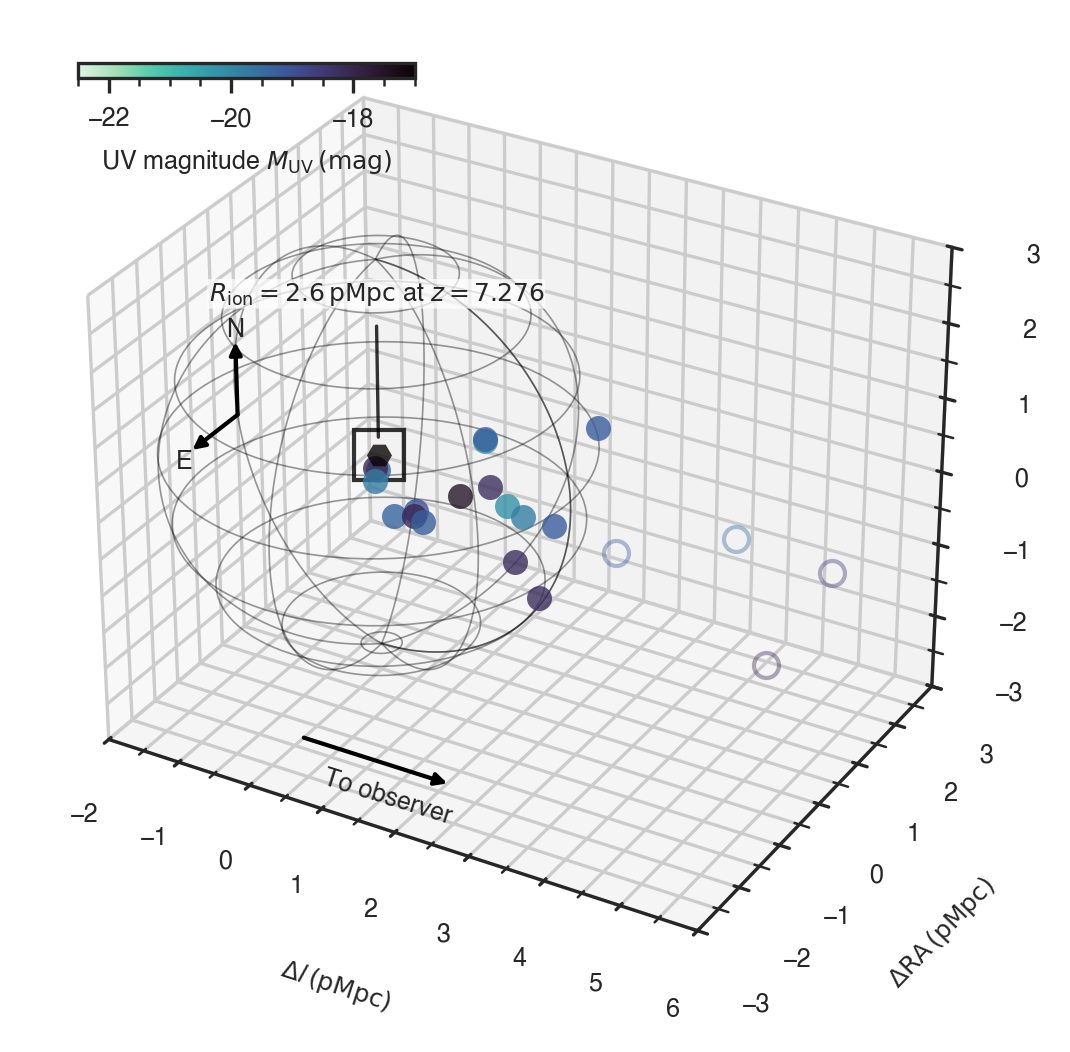

In [7]:
# Properties of ID 10013682 in GOODS-S, as reported by Witstok et al. (2024)
ID_LAE = 10013682
RA_LAE, Dec_LAE = 53.16746, -27.77201
sc_LAE = SkyCoord(RA_LAE, Dec_LAE, unit="deg")
pMpc_per_deg = cosmo.kpc_proper_per_arcmin(z_sys).to("Mpc/deg")

# Find nearby neighbours within a given separation in pMpc
max_separation_2D = 6.0 # pMpc
max_separation_LOS = 6.0 # pMpc
max_front_sep_LOS = 6.0 # pMpc
max_back_sep_LOS = 2.0 # pMpc

labelsize = "medium"
labelpad = 6
dx_mult = 0.3
dx = 4
dR = 1.0

# Set up the colourbar for UV magnitudes
M_norm = matplotlib.colors.Normalize(-22.5, -17)
M_cmap = matplotlib.colormaps.get_cmap("mako_r")
M_sm = matplotlib.cm.ScalarMappable(norm=M_norm, cmap=M_cmap)

# Prepare a 3D figure
fig = plt.figure(figsize=(8.27/2, 11.69/2))
ax = fig.add_subplot(projection="3d")
ax.tick_params(axis="both", which="both", labelsize=labelsize)

ax.set_xticks(np.arange(-10, 10, 0.5), minor=True)
ax.set_xticks(np.arange(-10, 10))
ax.set_yticks(np.arange(-10, 10, 0.5), minor=True)
ax.set_yticks(np.arange(-10, 10))
ax.set_zticks(np.arange(-10, 10, 0.5), minor=True)
ax.set_zticks(np.arange(-10, 10))

ax.set_xlim(-max_back_sep_LOS, max_front_sep_LOS)
ax.set_ylim(-0.5*max_separation_2D, 0.5*max_separation_2D)
ax.set_zlim(-0.5*max_separation_2D, 0.5*max_separation_2D)
ax.set_box_aspect((max_back_sep_LOS + max_front_sep_LOS, max_separation_2D, max_separation_2D))

ax.set_xlabel(r"$\Delta l \, (\mathrm{pMpc})$", labelpad=labelpad, size=labelsize)
ax.set_ylabel(r"$\Delta \mathrm{RA} \, (\mathrm{pMpc})$", size=labelsize)
ax.set_zlabel(r"$\Delta \mathrm{Dec} \, (\mathrm{pMpc})$", size=labelsize)

clb_M = fig.colorbar(M_sm, cax=ax.inset_axes(bounds=[0.05, 0.95, 0.35, 0.015]), orientation="horizontal")
clb_M.ax.tick_params(which="both", direction="out", labelsize=labelsize)
clb_M.set_label(r"UV magnitude $M_\mathrm{UV} \, (\mathrm{mag})$", size=labelsize)

obs_ann = ax.annotate3D("To observer", xyz=[0, -dx_mult*max_separation_2D, -0.5*max_separation_2D], xytext=(dx, -12), xycoords="data", textcoords="offset points",
                        va="bottom", ha="left", rotation=-17.5, rotation_mode="anchor")
obs_arr = ax.arrow3D(0, -dx_mult*max_separation_2D, -0.5*max_separation_2D, 2, 0, 0,
                        arrowstyle="-|>", mutation_scale=6, shrinkA=0, shrinkB=0, color='k')

E_ann = ax.annotate3D('E', xyz=(-max_back_sep_LOS, -1, 0), xytext=(0, 0), xycoords="data", textcoords="offset points",
                        va="top", ha="right")
E_arr = ax.arrow3D(-max_back_sep_LOS, 0, 0, 0, -1, 0,
                    arrowstyle="-|>", mutation_scale=6, shrinkA=0, shrinkB=0, color='k')
N_ann = ax.annotate3D('N', xyz=(-max_back_sep_LOS, 0, 1), xytext=(0, 0), xycoords="data", textcoords="offset points",
                        va="bottom", ha="center")
N_arr = ax.arrow3D(-max_back_sep_LOS, 0, 0, 0, 0, 1,
                    arrowstyle="-|>", mutation_scale=6, shrinkA=0, shrinkB=0, color='k')

ax.plot(0, 0, 0, linestyle="None", marker='H', mec="None", mfc=M_sm.to_rgba(M_UV_LAE), alpha=0.8, zorder=6)
ax.plot(0, 0, 0, linestyle="None", marker='s', markersize=2*def_markersize, mec='k', mfc="None", alpha=0.8, zorder=4)
ax.plot([0, 0], [0, 0], [0.25, np.nanmin([R_ion_esc, 1.0])+dR-0.25], color='k', alpha=0.8)

ax.annotate3D(r"$R_\mathrm{{ion}} = {:.2g} \, \mathrm{{pMpc}}$ at $z = {:.8g}$".format(R_ion_esc, z_sys),
                xyz=(0, 0, np.nanmin([R_ion_esc, 1.0])+dR), xytext=(0, 0),
                xycoords="data", textcoords="offset points",
                va="bottom", ha="center",
                bbox=dict(boxstyle="Round, pad=0.05", facecolor='w', edgecolor="None", alpha=0.7), zorder=6)

if R_ion_esc < max(max_separation_2D, max_separation_LOS):
    # Plot three-dimensional sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    ax.plot_wireframe(R_ion_esc * np.outer(np.cos(u), np.sin(v)), R_ion_esc * np.outer(np.sin(u), np.sin(v)), R_ion_esc * np.outer(np.ones(np.size(u)), np.cos(v)),
                        edgecolor='k', linewidth=0.5*def_linewidth, rstride=15, cstride=12, alpha=0.4)

# See which sources are close by along the line of sight
separations_LOS_pMpc = (cosmo.comoving_distance(z_sys) - cosmo.comoving_distance(z_specs_FRESCO)).to("Mpc").value / (1.0 + z_sys)
LAE_cluster = np.abs(separations_LOS_pMpc) < max(max_back_sep_LOS, max_front_sep_LOS)

neighbour_properties = []
for neighbour_property in [z_specs_FRESCO, RAs_FRESCO, Decs_FRESCO, M_UVs_FRESCO, M_UV_errs_FRESCO, beta_UVs_FRESCO, beta_UV_errs_FRESCO]:
    neighbour_properties.append(neighbour_property[LAE_cluster])

# Compute on-sky separations
separations_2D_pMpc = np.array([(sc_LAE.separation(SkyCoord(RA, Dec, unit="deg")) * pMpc_per_deg).to("Mpc").value for RA, Dec in zip(*neighbour_properties[1:3])])
separations_LOS_pMpc = separations_LOS_pMpc[LAE_cluster]

# Work out 3D separations using Pythagoras' theorem
separations_3D_pMpc = np.sqrt(separations_2D_pMpc**2 + separations_LOS_pMpc**2)
# Sort neighbours by 3D separation, selecting only those within certain 2D and LOS separations
sep_select = [idx for idx in np.argsort(separations_3D_pMpc) if separations_2D_pMpc[idx] < max_separation_2D and \
                separations_LOS_pMpc[idx] > -max_back_sep_LOS and separations_LOS_pMpc[idx] < max_front_sep_LOS]

neighbour_properties = [neighbour_property[sep_select] for neighbour_property in neighbour_properties]
neighbour_properties += [separations_LOS_pMpc[sep_select], separations_2D_pMpc[sep_select], separations_3D_pMpc[sep_select]]

dN_ion_dt_collective = 0.0

for z, RA, Dec, M_UV, M_UV_err, beta_UV, beta_UV_err, sep_LOS, sep_2D, sep_3D in zip(*neighbour_properties):
    # See if this source falls within the ionised bubble
    neighbour_ion = sep_3D < R_ion_esc
    # 3D coordinates (NB: right ascension increases going East)
    xyz = (sep_LOS, -((RA - RA_LAE) * units.deg * pMpc_per_deg).to("Mpc").value, ((Dec - Dec_LAE) * units.deg * pMpc_per_deg).to("Mpc").value)

    if neighbour_ion:
        dN_ion_dt_collective += 1.65e54 * 10**((M_UV+20)/-2.5) * (912.0/1500.0)**(beta_UV + 2)
        ax.plot(*xyz, linestyle="None", marker='o',
                mec="None", mfc=M_sm.to_rgba(M_UV), alpha=0.8, zorder=5)
    else:
        ax.plot(*xyz, linestyle="None", marker='o',
                mec=M_sm.to_rgba(M_UV), mfc="None", alpha=0.4, zorder=5)

print("The collective ionising photon production rate of all galaxies within the ionised bubble is dN_ion/dt = {:.2f} x 10^54 Hz.".format(dN_ion_dt_collective/1e54))

fig.savefig("../plots/10013682_3D_mapping" + pformat, dpi=dpi, bbox_inches="tight")

plt.show()
plt.close(fig)